In [ ]:
#default_exp laziness
from nbdev.showdoc import *
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Laziness Decay Graphs
Our previous measurements of diffusion laziness curvature have concentrated on scalar values assigned to each point. Granted, this reveals something of interest -- but could it reveal something more? What if, instead of having a single laziness value derived from a fixed aperture, we had charts of *dynamic* laziness as the aperture steadily increased? This would not only reveal the best aperture for distinguishing curvature based off a single scalar laziness value, but the rate of decay may reveal something more about the local geometry than a single curvature measurement.

In this notebook, we'll first define functions for producing these *Laziness Decay Graphs*, and then test them on a variety of datasets.

# Set Up
Here we get the dataset set up and define the laziness decay function.

In [ ]:
import diffusion_curvature # our main package
from diffusion_curvature.core import plot_3d, DiffusionMatrix
from diffusion_curvature.laziness import curvature
import numpy as np

Let's establish our tried and true dataset, the *torus*!

In [ ]:
from diffusion_curvature.datasets import torus
X = torus(n=5000,seed=42)
P = DiffusionMatrix(X,kernel_type='adaptive')
# the hyperparameters here are the kernel type and the kernel bandwidth. I've chosen them by hand to work well.

Distance to kth neighbors [0.44991467 0.43461588 0.34399481 ... 0.41987486 0.3873949  0.44752493]


In [ ]:
#export
def laziness_decay(P, max_steps = 32, aperture = 20, smoothing=1):
    """Generates a matrix of the decaying laziness value per point over a range of t values

    Parameters
    ----------
    P : ndarray
        Diffusion matrix
    max_steps : int, optional
        Number of diffusion steps to take (starting from 1), by default 32
    aperture : int, optional
        The size of the initial diffusion neighborhood, by default 20
    smoothing : int, optional
        Number of smmoothing interations, by default 1

    Returns
    -------
    ndarray
        Each column is a set of laziness values per point at a specific time.
    """
    # A prototype: TODO this is really inefficient, as it recomputes the diffusion powers each time!
    decay_per_point = np.empty((len(P),max_steps))
    P_t = P
    for t in range(1,max_steps+1):
        P_t = P_t @ P
        laziness = curvature(P,diffusion_powers=t,aperture=aperture,precomputed_powered_P=P_t,smoothing=smoothing)
        decay_per_point[:,t-1] = laziness
    return decay_per_point

In [ ]:
show_doc(laziness_decay)

<h4 id="laziness_decay" class="doc_header"><code>laziness_decay</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>laziness_decay</code>(**`P`**, **`max_steps`**=*`32`*, **`aperture`**=*`20`*, **`smoothing`**=*`1`*)

Generates a matrix of the decaying laziness value per point over a range of t values

Parameters
----------
P : ndarray
    Diffusion matrix
max_steps : int, optional
    Number of diffusion steps to take (starting from 1), by default 32
aperture : int, optional
    The size of the initial diffusion neighborhood, by default 20
smoothing : int, optional
    Number of smmoothing interations, by default 1

Returns
-------
ndarray
    Each column is a set of laziness values per point at a specific time.

Such a small function! But such power!
Let's test it on the donut.
It will also be informative to see how long it takes.

In [ ]:
%%time
decaying_lazy = laziness_decay(P, max_steps=32,aperture=20)

CPU times: user 1min 12s, sys: 4.15 s, total: 1min 17s
Wall time: 10.4 s


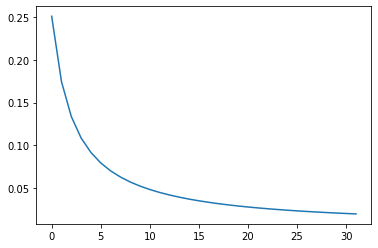

In [ ]:
import matplotlib.pyplot as plt
plt.plot(decaying_lazy[0])

These laziness decay plots look just as one would expect: the laziness decays. But does it decay differently in different regions? For this, we need to identify the indices of some points on the donut.

The torus function has been set up and so that the 0th point is on the outer rim, in a region of high positive curvature. The 1st point is in the inside, in a region of negative curvature, and the 2nd point is on the top, where the curvature should be closer to zero.

But let's first verify that the laziness is tracking with the curvature here.

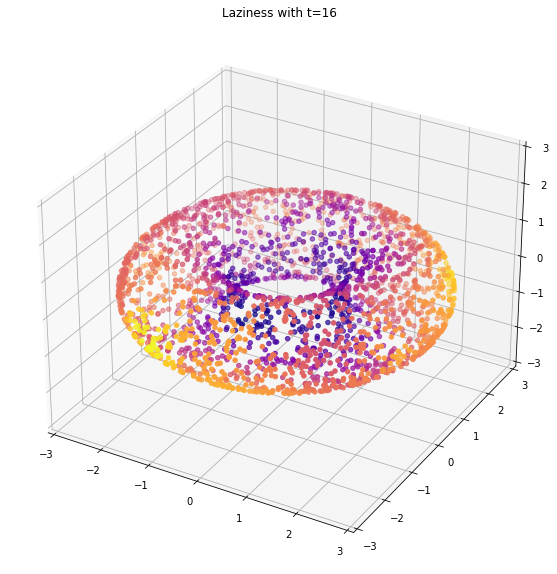

In [ ]:
plot_3d(X,decaying_lazy[:,8],title="Laziness with t=16")

In [ ]:
plot_3d(X,decaying_lazy[:,16],title="Laziness with t=16",use_plotly=True)

Let's visualize our target points:

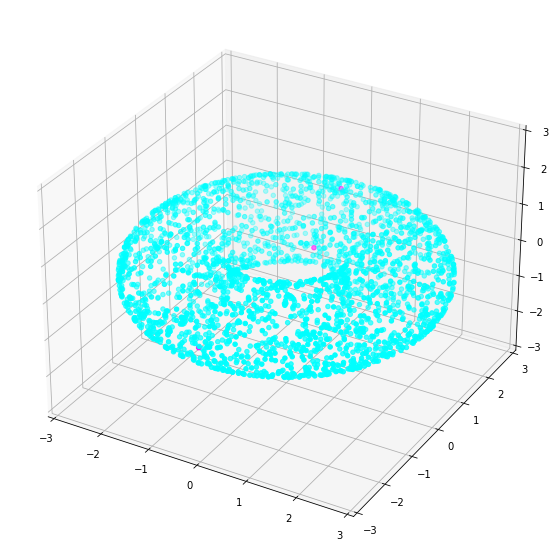

In [ ]:
dist = np.zeros(len(X))
dist[0] = 1
dist[1] = 1
dist[2] = 1
plot_3d(X,dist,cmap="cool")

# Decay Graphs, with minimal smoothing

At last, we can draw a laziness decay graph!

Text(0, 0.5, 'Laziness')

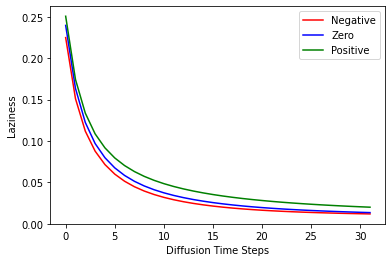

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(decaying_lazy[1],color='red',label='Negative')
ax.plot(decaying_lazy[2],color='blue',label='Zero')
ax.plot(decaying_lazy[0],color='green',label='Positive')
ax.legend()
ax.set_xlabel("Diffusion Time Steps")
ax.set_ylabel("Laziness")

As expected, the point of negative curvature decays fastest, and the positively curved point is the most leisurely.

This graph also illustrates the diffusion time steps which optimally emphasize the contrast between these points. Anywhere from 7 to 20 appears reasonable.